In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
df_nifty = pd.read_csv('NIFTY.csv')
df_vix = pd.read_csv('VIX.csv')

/var/folders/ss/4fy1wy_17qq9x8pms7k73r940000gn/T/ipykernel_95628/1762543078.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_nifty["Date"] = pd.to_datetime(df_nifty["Date"])
/var/folders/ss/4fy1wy_17qq9x8pms7k73r940000gn/T/ipykernel_95628/1762543078.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_vix["Date"] = pd.to_datetime(df_vix["Date"])


<Figure size 1200x600 with 0 Axes>

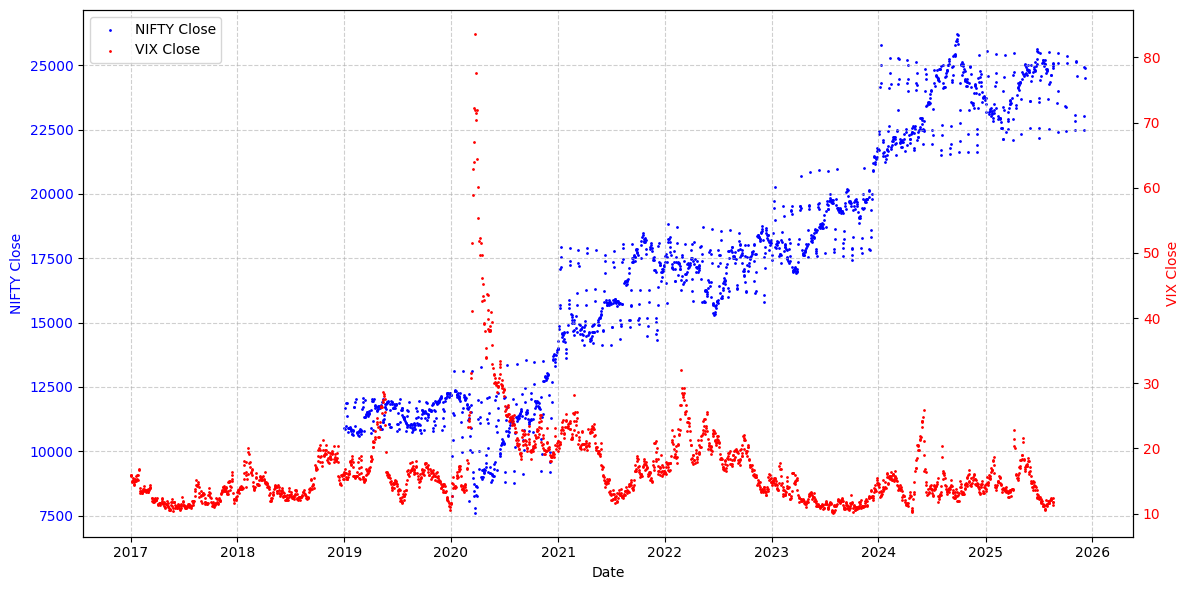

In [3]:

df_nifty["Date"] = pd.to_datetime(df_nifty["Date"])
df_vix["Date"] = pd.to_datetime(df_vix["Date"])

df_nifty.set_index("Date", inplace=True)
df_nifty.sort_values("Date", inplace=True)

df_vix.set_index("Date", inplace=True)
df_vix.sort_values("Date", inplace=True)


## PLOT BOTH NIFTY AND VIX

plt.figure(figsize=(12, 6))
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.scatter(df_nifty.index, df_nifty["Close"], s=1, color="blue", label="NIFTY Close")
ax1.set_xlabel("Date")
ax1.set_ylabel("NIFTY Close", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.scatter(df_vix.index, df_vix["Close"], s=1, color="red", label="VIX Close")
ax2.set_ylabel("VIX Close", color="red")
ax2.tick_params(axis="y", labelcolor="red")

ax1.grid(True, which="both", linestyle="--", alpha=0.6)
fig.tight_layout()

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.show()

In [4]:


class MacroFeatureExtractor:
    def __init__(self, df_nifty, df_vix):
        self.df_nifty = df_nifty[["Close"]].copy()
        self.df_vix = df_vix[["Close"]].copy()
        self.final_df = None

    def _create_rolling_returns(self, window_days=30):
        self.df_nifty[f"rolling_returns_{window_days}d"] = np.log(
            self.df_nifty["Close"] / self.df_nifty["Close"].shift(window_days)
        )

    def _compute_rsi(self, window_days=14):
        delta = self.df_nifty['Close'].diff()
        gain = pd.Series(np.where(delta > 0, delta, 0), index=self.df_nifty.index)
        loss = pd.Series(np.where(delta < 0, -delta, 0), index=self.df_nifty.index)

        avg_gain = gain.ewm(alpha=1/window_days, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/window_days, adjust=False).mean()

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        self.df_nifty[f'RSI_{window_days}d'] = rsi

    def _create_ma_spreads(self, long_window=60, short_window=20):
        self.df_nifty[f"short_{short_window}_long_{long_window}_term_diff"] = np.log(
            self.df_nifty['Close'].rolling(short_window).mean()
            / self.df_nifty['Close'].rolling(long_window).mean()
        )

    def _create_ma(self, window=20):
        self.df_nifty["Close"] = self.df_nifty['Close'].rolling(window).mean()

    def _max_drawdown(self, window_days=30):
        rolling_max = self.df_nifty["Close"].rolling(window_days, min_periods=1).max()
        drawdown = self.df_nifty["Close"] / rolling_max - 1
        self.df_nifty[f"max_drawdown_{window_days}d"] = drawdown.rolling(window_days, min_periods=1).min()

    def _bollinger_bands(self, window=20):
        ma = self.df_nifty["Close"].rolling(window).mean()
        std = self.df_nifty["Close"].rolling(window).std()
        self.df_nifty[f"bollinger_zscore_{window}d"] = (self.df_nifty["Close"] - ma) / std

    def _roc(self, window=10):
        self.df_nifty[f"roc_{window}d"] = self.df_nifty["Close"].pct_change(periods=window)

    def _vol_adj_momentum(self, window=30):
        ret = self.df_nifty["Close"].pct_change(window)
        vol = self.df_nifty["Close"].pct_change().rolling(window).std()
        self.df_nifty[f"sharpe_like_{window}d"] = ret / vol

    def _rolling_volatility(self, window=30):
        self.df_nifty[f"volatility_{window}d"] = self.df_nifty["Close"].pct_change().rolling(window).std()

    def _downside_vol(self, window=30):
        ret = self.df_nifty["Close"].pct_change()
        downside = ret.where(ret < 0, 0)
        self.df_nifty[f"downside_vol_{window}d"] = downside.rolling(window).std()

    def _higher_moments(self, window=60):
        returns = self.df_nifty["Close"].pct_change()
        self.df_nifty[f"skew_{window}d"] = returns.rolling(window).skew()
        self.df_nifty[f"kurt_{window}d"] = returns.rolling(window).kurt()


    def _process_vix_basic(self):
        self.df_vix["VIX_rolling_mean_30d"] = self.df_vix["Close"].rolling(30).mean()
        self.df_vix["VIX_rolling_std_30d"] = self.df_vix["Close"].rolling(30).std()

    def _vol_of_vol(self, window=30):
        self.df_vix[f"vol_of_vol_{window}d"] = self.df_vix["Close"].pct_change().rolling(window).std()

    def _nifty_vix_ratio(self):
        self.df_merged["nifty_vix_ratio"] = (
            self.df_merged["Close"] / self.df_merged["VIX_rolling_mean_30d"]
        )

    def process_nifty(self):
        self._create_ma(window=7)##smoothens the curve for long term prices
        self._compute_rsi(window_days=40) ## checks for long time overbought/oversold conditions
        self._create_ma_spreads(long_window=80, short_window=40) ## checks for any medium term trends
        self._max_drawdown(window_days=40) 
        self._vol_adj_momentum(window=40) 
        self._rolling_volatility(window=40)
        self.df_nifty = self.df_nifty.dropna()

    def process_vix(self):
        self._process_vix_basic()
        self.df_vix = self.df_vix.dropna()

    def merge_dfs(self):
        self.df_vix.drop(columns=["Close"], inplace=True)
        self.df_merged = self.df_nifty.join(self.df_vix, how="inner")
        self.df_merged = self.df_merged.dropna()
        self._nifty_vix_ratio()
    
        self.df_merged = self.df_merged.dropna()
        self.final_df = self.df_merged.copy()

    def scale_df(self):
        from sklearn.preprocessing import StandardScaler

        features = self.df_merged.drop(columns=["Close"]) 
        self.scaler = StandardScaler()
        scaled_features = self.scaler.fit_transform(features) 
        self.df_merged_scaled = pd.DataFrame(
            scaled_features, index=features.index, columns=features.columns
        )
        self.df_merged_scaled['Close'] = self.df_merged['Close']
        self.final_df = self.df_merged_scaled.copy()


    def process(self):
        self.process_nifty()
        self.process_vix()
        self.merge_dfs()
        self.scale_df()

In [5]:
mfe = MacroFeatureExtractor(df_nifty, df_vix)

In [6]:
mfe.process()

In [7]:
import numpy as np
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

class RegimeClassifier:
    def __init__(self):
        pass
    
    def initialise_model(self, model_class, params: dict):
        """
        Initialise HMM (or any sklearn-like model) with params.
        """
        return model_class(**params)

    def get_regimes_hmm(self, input_data: np.ndarray, params: dict):
        """
        Train an HMM model on input_data and return fitted model + regimes.
        """
        X = np.array(input_data)
        hmm_model = self.initialise_model(GaussianHMM, params).fit(X)
        regimes = hmm_model.predict(X)
        return hmm_model, regimes

    def get_cluster_centres(self, hmm_model):
        """Return the mean vectors (cluster centres) for each regime."""
        return hmm_model.means_
    
    def _count_hmm_params(self, model):
        """Count number of free parameters in Gaussian HMM."""
        M = model.n_components
        d = model.n_features
        cov_type = model.covariance_type
        
        init_params = M - 1
        trans_params = M * (M - 1)
        mean_params = M * d
        
        if cov_type == "full":
            cov_params = M * d * (d + 1) // 2
        elif cov_type == "diag":
            cov_params = M * d
        else:
            raise ValueError(f"Unsupported covariance type: {cov_type}")
        
        return init_params + trans_params + mean_params + cov_params

    def evaluate_models(self, X, ns=[2, 3, 4, 5, 6], n_init=10, random_state=None):
        """
        Fit HMMs with different numbers of components and evaluate using AIC, BIC, and log-likelihood.
        
        X : np.ndarray
        ns : list of int -> number of components to try
        n_init : int -> how many times to refit each model and keep the best
        random_state : int -> for reproducibility
        """
        aic, bic, lls = [], [], []
        
        for n in ns:
            best_ll = None
            best_model = None
            for i in range(n_init):
                h = GaussianHMM(n_components=n, n_iter=200, tol=1e-4, random_state=random_state)
                h.fit(X)
                score = h.score(X)
                if (best_ll is None) or (score > best_ll):
                    best_ll = score
                    best_model = h
            
            k = self._count_hmm_params(best_model)
            n_samples = len(X)
            AIC = 2 * k - 2 * best_ll
            BIC = np.log(n_samples) * k - 2 * best_ll
            
            aic.append(AIC)
            bic.append(BIC)
            lls.append(best_ll)

        # Plot results
        fig, ax = plt.subplots()
        ln1 = ax.plot(ns, aic, label="AIC", color="blue", marker="o")
        ln2 = ax.plot(ns, bic, label="BIC", color="green", marker="o")
        ax2 = ax.twinx()
        ln3 = ax2.plot(ns, lls, label="Log-Likelihood", color="orange", marker="o")

        ax.legend(handles=ax.lines + ax2.lines)
        ax.set_title("Using AIC/BIC for Model Selection")
        ax.set_ylabel("Criterion Value (lower is better)")
        ax2.set_ylabel("Log-Likelihood (higher is better)")
        ax.set_xlabel("Number of HMM Components")
        fig.tight_layout()
        plt.show()

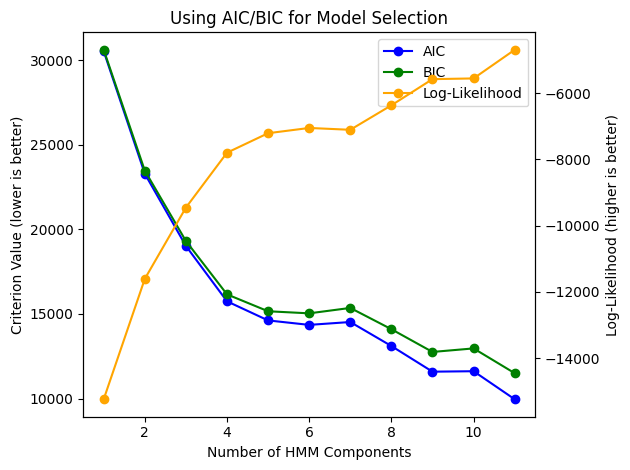

In [8]:

clf = RegimeClassifier()
results = clf.evaluate_models(mfe.final_df.drop(columns=['Close']), ns=list(range(1, 12)), n_init=10, random_state=42)

From the above aic-bic diagram, we see that 6 is a good enough number of clusters

In [9]:

clf = RegimeClassifier()

params = {
    "n_components": 6,
    "covariance_type": "full",
    "n_iter": 50,        
    "tol": 1e-4,         
    "verbose": True,     
    "random_state": 42,
}
                
model, regimes = clf.get_regimes_hmm(mfe.final_df.drop(columns=['Close']), params)
mfe.final_df["Regime"] = regimes

         1  -11588.14610281             +nan
         2   -7409.49013845   +4178.65596435
         3   -5636.23654716   +1773.25359129
         4   -5077.38665990    +558.84988726
         5   -4931.04356823    +146.34309166
         6   -4849.56332742     +81.48024081
         7   -4818.44704035     +31.11628707
         8   -4765.00803956     +53.43900079
         9   -4716.82985494     +48.17818462
        10   -4652.90887981     +63.92097513
        11   -4619.57756456     +33.33131524
        12   -4598.88041533     +20.69714924
        13   -4582.88757681     +15.99283852
        14   -4528.44780074     +54.43977608
        15   -4507.54280116     +20.90499958
        16   -4505.81661358      +1.72618758
        17   -4505.16157989      +0.65503369
        18   -4504.59841243      +0.56316746
        19   -4501.96881619      +2.62959624
        20   -4485.22131728     +16.74749891
        21   -4477.13691881      +8.08439847
        22   -4472.88610608      +4.25081273
        23

In [10]:
centres = pd.DataFrame(mfe.scaler.inverse_transform(clf.get_cluster_centres(model)), columns=mfe.final_df.drop(columns=['Close', 'Regime']).columns)
centres

,RSI_40d,short_40_long_80_term_diff,max_drawdown_40d,sharpe_like_40d,volatility_40d,VIX_rolling_mean_30d,VIX_rolling_std_30d,nifty_vix_ratio
0,53.826100,0.028627,-0.097278,2.275706,0.012436,20.582167,1.788930,807.663819
1,52.693908,0.007736,-0.081427,1.203967,0.010093,13.556814,0.961961,1527.343108
2,41.448923,-0.063241,-0.305272,-5.369963,0.027400,44.015693,15.096103,234.144193
3,53.996735,0.029099,-0.097325,2.420149,0.012408,20.625815,1.794988,808.078788
4,54.646359,0.009130,-0.060237,3.725315,0.007362,14.705650,1.570547,1315.823341
5,52.827205,0.004627,-0.124807,2.361374,0.014803,20.330487,2.184542,715.037741


In [16]:
print(centres)

     RSI_40d  short_40_long_80_term_diff  max_drawdown_40d  sharpe_like_40d  \
0  53.826100                    0.028627         -0.097278         2.275706   
1  52.693908                    0.007736         -0.081427         1.203967   
2  41.448923                   -0.063241         -0.305272        -5.369963   
3  53.996735                    0.029099         -0.097325         2.420149   
4  54.646359                    0.009130         -0.060237         3.725315   
5  52.827205                    0.004627         -0.124807         2.361374   

   volatility_40d  VIX_rolling_mean_30d  VIX_rolling_std_30d  nifty_vix_ratio  
0        0.012436             20.582167             1.788930       807.663819  
1        0.010093             13.556814             0.961961      1527.343108  
2        0.027400             44.015693            15.096103       234.144193  
3        0.012408             20.625815             1.794988       808.078788  
4        0.007362             14.705650       

In [ ]:
mfe.final_df.rename(columns={"Regime": "macro_regime"}, inplace=True)

In [ ]:
import plotly.express as px
import pandas as pd

def plot_graph_plotly(df):
    print(df["macro_regime"].value_counts())
    
    df = df.copy()
    df["macro_regime"] = df["macro_regime"].astype(str)  # ensure categorical

    for col in df.columns:
        if col == "macro_regime":
            continue

        if col.lower() == "close":
            # Scatter plot vs Date
            fig = px.scatter(
                df,
                x=df.index,
                y=col,
                color="macro_regime",
                labels={"x": "Date", "y": col, "color": "macro_regime"},
                title=f"{col} vs Date (colored by regime)",
                hover_data=[col]
            )
            fig.update_traces(marker=dict(size=6), selector=dict(mode='markers'))
            fig.update_layout(legend_title_text='macro_regime')
            fig.show()
        else:
            # Violin plot by regime
            fig = px.violin(
                df,
                x="macro_regime",
                y=col,
                color="macro_regime",
                box=True,  # show box inside violin
                points="all",  # show all points
                hover_data=[col],
                title=f"Distribution of {col} by Regime"
            )
            fig.update_layout(yaxis_title=col, xaxis_title="Regime")
            fig.show()

# Usage
plot_graph_plotly(mfe.final_df)

	•	Cluster 0 → Bullish_LowVol
	•	Cluster 1 → Bullish_VeryLowVol
	•	Cluster 2 → Bearish_HighVol
	•	Cluster 3 → Bullish_LowVol
	•	Cluster 4 → Bullish_CalmMomentum
	•	Cluster 5 → Bullish_MidVol

here, it makes sense from an interpretation perspective that we merge clusters. we are merging 0-3 and 1-4
so the final number of clusters we take is 4

In [ ]:

mfe.final_df["macro_regime"].replace(
    {
        0: "Bullish_LowVol",
        1: "Bullish_VeryLowVol",
        2: "Bearish_HighVol",
        3: "Bullish_LowVol",
        4: "Bullish_VeryLowVol",
        5: "Bullish_MidVol"
    },
    inplace=True,
)

/var/folders/ss/4fy1wy_17qq9x8pms7k73r940000gn/T/ipykernel_95628/1181045088.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [19]:
plot_graph_plotly(mfe.final_df)

macro_regime
Bullish_VeryLowVol    727
Bullish_LowVol        312
Bullish_MidVol        261
Bearish_HighVol        43
Name: count, dtype: int64


In [13]:
import pandas as pd


def compute_regime_persistence(df, regime_col="macro_regime"):
    df = df.copy()
    df["macro_regime_change"] = df[regime_col].ne(df[regime_col].shift()).cumsum()

    # Group consecutive same-regime stretches
    persistence = (
        df.groupby([regime_col, "macro_regime_change"])
        .size()
        .reset_index(name="Duration")
    )

    # For each regime, compute stats
    summary = (
        persistence.groupby(regime_col)["Duration"]
        .agg(["count", "mean", "median", "max", "min"])
        .reset_index()
    )
    
    return persistence, summary

persistence, summary = compute_regime_persistence(mfe.final_df, regime_col="macro_regime")

print("\nSummary by regime:")
print(summary)


Summary by regime:
         macro_regime  count     mean  median  max  min
0     Bearish_HighVol      1   43.000    43.0   43   43
1      Bullish_LowVol      8   39.000    29.0   85    9
2      Bullish_MidVol      8   32.625    36.0   50    5
3  Bullish_VeryLowVol      4  181.750   179.0  304   65


In [14]:
final_features = ['RSI_40d', 'short_40_long_80_term_diff', 'max_drawdown_40d',
       'sharpe_like_40d', 'volatility_40d', 'VIX_rolling_mean_30d',
       'VIX_rolling_std_30d', 'nifty_vix_ratio']


mfe.final_df[final_features] = mfe.scaler.inverse_transform(mfe.final_df[final_features])

In [15]:
mfe.final_df.to_csv("macro_features_with_regimes.csv")